# Pickle load

In [1]:
import pickle

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

data = data.reset_index(drop=True, inplace=False)

In [ ]:
import numpy as np
import pandas as pd

true_data = pd.read_csv('data/True.csv')
fake_data = pd.read_csv('data/Fake.csv')

In [ ]:
print("True articles")
true_data.head()


In [ ]:
print("Fake articles")
fake_data.head()

In [ ]:
true_data.describe()

In [ ]:
# Creating a single dataset with labels for true = 1 and false = 0

true_data['label'] = 1
fake_data['label'] = 0

# Cleaning true_data before concatinating
## Removing journal identifier
true_data['text'] = true_data['text'].str.partition('- ')[2]

# Removing duplicates rows of titles where text is empty
# Create a placeholder to check if text is empty
is_text_functionally_empty = (
    true_data['text'].isna() | 
    true_data['text'].astype(str).str.strip().eq('')
)
rows_to_drop = true_data[is_text_functionally_empty].duplicated(subset=['title'], keep='first')
drop_indices = true_data[is_text_functionally_empty][rows_to_drop].index
cleaned_true = true_data.drop(index=drop_indices)
# Doing the same for fake articles
fake_is_text_functionally_empty = (
    fake_data['text'].isna() | 
    fake_data['text'].astype(str).str.strip().eq('')
)
rows_to_drop = fake_data[fake_is_text_functionally_empty].duplicated(subset=['title'], keep='first')
drop_indices = fake_data[fake_is_text_functionally_empty][rows_to_drop].index
cleaned_fake = fake_data.drop(index=drop_indices)

print(f"Removed {len(true_data)-len(cleaned_true)} duplicate title rows from true articles")
print(f"Removed {len(fake_data)-len(cleaned_fake)} duplicate title rows from fake articles")
print("")

# Removing duplicates of text but keeping unique rows of title
has_content = ~(
    cleaned_fake['text'].isna() |
    cleaned_fake['text'].astype(str).str.strip().eq('')
)
rows_to_remove = cleaned_fake[has_content].duplicated(subset=['text'], keep='first')

drop_indices = cleaned_fake[has_content][rows_to_remove].index

new_cleaned_fake = cleaned_fake.drop(index=drop_indices)

# Doing the same for true articles

has_content = ~(
    cleaned_true['text'].isna() |
    cleaned_true['text'].astype(str).str.strip().eq('')
)
rows_to_remove = cleaned_true[has_content].duplicated(subset=['text'], keep='first')

drop_indices = cleaned_true[has_content][rows_to_remove].index

new_cleaned_true = cleaned_true.drop(index=drop_indices)

print(f"Removed {len(cleaned_true)-len(new_cleaned_true)} duplicate text rows from true articles")
print(f"Removed {len(cleaned_fake)-len(new_cleaned_fake)} duplicate text rows from fake articles")
print("______________________________________________________________________")
print(f"Removed {len(true_data)-len(new_cleaned_true)} duplicate rows from true articles in total")
print(f"Removed {len(fake_data)-len(new_cleaned_fake)} duplicate rows from fake articles in total")

# Concatinating dataframes
data = pd.concat([new_cleaned_true, new_cleaned_fake])

In [ ]:
# Text standardizing
import string


# Creating new columns to preserve original text
data['title_standard'] = data['title']
data['text_standard'] = data['text']

# Removing punctuations including special letter which didn't get picked up by string.punctuation
punctuation_and_special = string.punctuation + '“”‘’' 
punctuation = str.maketrans('', '', punctuation_and_special)

data['title_standard'] = data['title'].astype(str).str.translate(punctuation)
data['text_standard'] = data['text'].astype(str).str.translate(punctuation)

# Lowercasing 
data['title_standard'] = data['title_standard'].astype(str).str.strip().str.lower()
data['text_standard'] = data['text_standard'].astype(str).str.strip().str.lower()


# Naive bayes

In [5]:
# Baseline naive bayes model for article texts
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# Define Features (X) and Target (y)
X = data['text_standard']  
y = data['label']

# Splitting the data and making sure we get the same number of labels in each set with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
)

# Setting max_df to 0.7 we exclude words that appears in more than 70% of all articles in the training set so we should get more unique words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_train_counts = count_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_counts = count_vectorizer.transform(X_test)

# Train Multinomial Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, y_train)

# 5. Predict and Evaluate
y_pred_counts = nb_classifier.predict(X_test_counts)

# Get the feature names to see which words are helping us predict
feature_names = count_vectorizer.get_feature_names_out()

# Getting log coefficients 
log_probs_fake = nb_classifier.feature_log_prob_[0]
log_probs_true = nb_classifier.feature_log_prob_[1]

# Create a DataFrame so we can sort them 
feature_df = pd.DataFrame({
    'feature': feature_names,
    'log_prob_fake': log_probs_fake,
    'log_prob_true': log_probs_true
})

# Calculate the difference between coefficients 
# A larger positive difference means the word is highly associated with fake news
feature_df['fake_score'] = feature_df['log_prob_fake'] - feature_df['log_prob_true']

# 5. Get top 20 for Fake (highest positive scores)
top_fake_features = feature_df.sort_values(by='fake_score', ascending=False).head(20)

# 6. Get top 20 for True (lowest negative scores)
top_true_features = feature_df.sort_values(by='fake_score', ascending=True).head(20)


# Print results
print("--- Naive Bayes Classification Results (Using Raw Word Counts) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_counts):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_counts))

# Print important classifying words
print("--- Top 20 Words Predicting FAKE News (Label 0) ---")
print(top_fake_features[['feature', 'fake_score']].to_markdown(index=False))

print("\n--- Top 20 Words Predicting TRUE News (Label 1) ---")
print(top_true_features[['feature', 'fake_score']].to_markdown(index=False))

--- Naive Bayes Classification Results (Using Raw Word Counts) ---
Accuracy: 0.9424

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3580
           1       0.93      0.97      0.95      4237

    accuracy                           0.94      7817
   macro avg       0.94      0.94      0.94      7817
weighted avg       0.94      0.94      0.94      7817

--- Top 20 Words Predicting FAKE News (Label 0) ---
| feature             |   fake_score |
|:--------------------|-------------:|
| 2017realdonaldtrump |      7.0647  |
| 21wire              |      6.35848 |
| belowfeatured       |      6.28281 |
| getty               |      6.2585  |
| 2017the             |      6.08819 |
| flickr              |      6.06944 |
| 21wiretv            |      5.91799 |
| 2016realdonaldtrump |      5.82926 |
| somodevillagetty    |      5.74693 |
| screenshot          |      5.74319 |
| acr                 |      5.70112 |
| cda

In [ ]:
# We do the same for the article titles

X = data['title_standard']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
count_vectorizer = CountVectorizer(stop_words='english')


X_train_counts = count_vectorizer.fit_transform(X_train)


X_test_counts = count_vectorizer.transform(X_test)


nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, y_train)


y_pred_counts = nb_classifier.predict(X_test_counts)

feature_names = count_vectorizer.get_feature_names_out()

log_probs_fake = nb_classifier.feature_log_prob_[0]
log_probs_true = nb_classifier.feature_log_prob_[1]


feature_df = pd.DataFrame({
    'feature': feature_names,
    'log_prob_fake': log_probs_fake,
    'log_prob_true': log_probs_true
})

feature_df['fake_score'] = feature_df['log_prob_fake'] - feature_df['log_prob_true']
top_fake_features = feature_df.sort_values(by='fake_score', ascending=False).head(20)
top_true_features = feature_df.sort_values(by='fake_score', ascending=True).head(20)

print("--- Naive Bayes Classification Results (Using Raw Word Counts) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_counts):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_counts))
print("--- Top 20 Words Predicting FAKE News (Label 0) ---")
print(top_fake_features[['feature', 'fake_score']].to_markdown(index=False))
print("\n--- Top 20 Words Predicting TRUE News (Label 1) ---")
print(top_true_features[['feature', 'fake_score']].to_markdown(index=False))

In [ ]:
# Added cleaning step to handle noise in fake articles
data['text_cleaned'] = data['text_standard']
# Remove common URL patterns and link shorteners
data['text_cleaned'] = data['text_cleaned'].str.replace(r'http[s]?://\S+|www\.\S+|\S+\.(com|org|net|co|ly)|pictwittercom|httpstco|bitly', '', regex=True)
# Remove photo/site credit words (getty, flickr, wikimedia, etc.)
credit_patterns = r'getty|flickr|wikimedia|belowfeatured|somodevillagetty|mcnameegetty|angerergetty|wiretv|acr|cdata|filessupport'
data['text_cleaned'] = data['text_cleaned'].str.replace(credit_patterns, '', regex=True)
# Remove common code snippets and internal tags
code_patterns = r'var|js|dgetelementsbytagnames|dcreateelements|dgetelementbyidid|jssrc|jsid|wfb|featured|screenshot|raedle|gage|donnell|whinedr|src|xfbml|parentnodeinsertbefore|versionv|screengrab|subscribing|nyp'
data['text_cleaned'] = data['text_cleaned'].str.replace(code_patterns, ' ', regex=True)
# Find all words that consist only of letters (a-z) and more than 2 characters long to get rid of fx 21Wire
data['text_cleaned'] = data['text_cleaned'].str.findall(r'[a-z]{2,}')
# Join the tokenized words into single string again
data['text_cleaned'] = data['text_cleaned'].str.join(' ')



# Naive bayes v2

In [6]:

# Define Features (X) and Target (y)
X = data['text_cleaned']  
y = data['label']

# Splitting the data and making sure we get the same number of labels in each set with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
)

# Setting max_df to 0.7 we exclude words that appears in more than 70% of all articles in the training set so we should get more unique words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_train_counts = count_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_counts = count_vectorizer.transform(X_test)

# Train Multinomial Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, y_train)

# 5. Predict and Evaluate
y_pred_counts = nb_classifier.predict(X_test_counts)

# Get the feature names to see which words are helping us predict
feature_names = count_vectorizer.get_feature_names_out()

# Getting log coefficients 
log_probs_fake = nb_classifier.feature_log_prob_[0]
log_probs_true = nb_classifier.feature_log_prob_[1]

# Create a DataFrame so we can sort them 
feature_df = pd.DataFrame({
    'feature': feature_names,
    'log_prob_fake': log_probs_fake,
    'log_prob_true': log_probs_true
})

# Calculate the difference between coefficients 
# A larger positive difference means the word is highly associated with fake news
feature_df['fake_score'] = feature_df['log_prob_fake'] - feature_df['log_prob_true']

# 5. Get top 20 for Fake (highest positive scores)
top_fake_features = feature_df.sort_values(by='fake_score', ascending=False).head(20)

# 6. Get top 20 for True (lowest negative scores)
top_true_features = feature_df.sort_values(by='fake_score', ascending=True).head(20)


# Print results
print("--- Naive Bayes Classification Results (Using Raw Word Counts) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_counts):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_counts))

# Print important classifying words
print("--- Top 20 Words Predicting FAKE News (Label 0) ---")
print(top_fake_features[['feature', 'fake_score']].to_markdown(index=False))

print("\n--- Top 20 Words Predicting TRUE News (Label 1) ---")
print(top_true_features[['feature', 'fake_score']].to_markdown(index=False))

--- Naive Bayes Classification Results (Using Raw Word Counts) ---
Accuracy: 0.9418

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3580
           1       0.93      0.96      0.95      4237

    accuracy                           0.94      7817
   macro avg       0.94      0.94      0.94      7817
weighted avg       0.94      0.94      0.94      7817

--- Top 20 Words Predicting FAKE News (Label 0) ---
| feature        |   fake_score |
|:---------------|-------------:|
| reilly         |      5.38192 |
| finicum        |      5.36565 |
| fcking         |      5.23757 |
| henningsen     |      5.18661 |
| whined         |      5.09064 |
| bundy          |      5.05214 |
| hammonds       |      4.81013 |
| behar          |      4.81013 |
| fck            |      4.7909  |
| shit           |      4.7844  |
| somodevilla    |      4.77129 |
| watters        |      4.75129 |
| elizabethforma |      4.74114 |
| 

# Creating embeddings

In [14]:
# CREATING EMBEDDINGS
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sentence_transformers import SentenceTransformer

# Initialize the encoder
## all-miniLM-L6-v2 truncates sentences longer than 256 words, meaning that only the first 256 words of the sentences are embedded
sent_encoder = SentenceTransformer('all-MiniLM-L12-v2')

# Extract columns and convert to lists (using existing column names)
title_list = data['title_standard'].tolist()

# Generate embeddings for titles which consist of one sentence 
title_embeddings = sent_encoder.encode(title_list, show_progress_bar=True)

# Correctly store the 2D arrays back into the DataFrame
data['title_embedding'] = pd.Series(list(title_embeddings), index=data.index)

Batches: 100%|██████████| 1222/1222 [00:26<00:00, 46.23it/s]


In [ ]:
data['title_embedding'].iloc[0].shape

# Classifying with cosine

In [ ]:
text_features = np.stack(data['aggregated_text_embedding'].to_numpy())
# Dimensionality reduction for better to handle large matrices
import umap

# Use the full title_embeddings matrix (UMAP can handle it better than t-SNE)
reducer = umap.UMAP(n_components=2, random_state=20)

X_umap = reducer.fit_transform(text_features)


In [19]:
from sklearn.model_selection import train_test_split

#-------- Uncomment one of the text_features to choose between the title sentence embeddings or the text embeddings------------_"

#text_features = np.stack(data['title_embedding'].to_numpy())
text_features = np.stack(data['aggregated_text_embedding'].to_numpy())

X = text_features
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [20]:
df_train = pd.DataFrame({'embeddings': list(X_train), 'label': y_train})

title_mean = df_train.groupby('label')['embeddings'].apply(
    lambda x: np.mean(np.stack(x.values), axis=0)
)

title_mean_true = title_mean[1]
title_mean_fake = title_mean[0]

In [21]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import classification_report, accuracy_score


mean_matrix = np.stack([title_mean_fake, title_mean_true])


distance_matrix = cosine_distances(X_test, mean_matrix)


y_pred = np.argmin(distance_matrix, axis=1)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Fake (0)', 'True (1)'])

print("---------ARTICLE TEXT")
print(f"Accuracy on unseen Test Set: {accuracy:.4f}")
print(report)

---------ARTICLE TEXT
Accuracy on unseen Test Set: 0.8626
              precision    recall  f1-score   support

    Fake (0)       0.83      0.89      0.86      3580
    True (1)       0.90      0.84      0.87      4237

    accuracy                           0.86      7817
   macro avg       0.86      0.86      0.86      7817
weighted avg       0.87      0.86      0.86      7817



# TOPICS

In [ ]:
from transformers import pipeline
from tqdm.auto import tqdm
tqdm.pandas()

topic_classifier = pipeline("text-classification", model="classla/multilingual-IPTC-news-topic-classifier", device=0, max_length=512, truncation=True)


#print(f"Applying topic classifier to {len(data['text_cleaned'])} articles. This might take a while...")
#data['topic_predictions'] = data['text_cleaned'].progress_apply(lambda x: topic_classifier(x)[0] if pd.notna(x) and x != '' else None)

In [ ]:
import pandas as pd
import numpy as np
import string
import re
from collections.abc import Iterable
# A. Initial Split (We use the original 'text' column)
data['sentence_list'] = data['text'].str.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', expand=False)
# Using a more sophisticated regex split above to better handle titles/abbreviations like 'U.S.'

def clean_and_filter_sentences(sentence_list):
    """Strips whitespace and filters out empty/short strings."""
    try:
        if pd.isna(sentence_list).all():
            return []
    except AttributeError:
        # Fallback for single-element NaNs (which don't have a .all() method)
        if pd.isna(sentence_list):
            return []
    
    # --------------------------------------------------------------------------
    
    # 1. Force array-like objects into a Python list
    if isinstance(sentence_list, (np.ndarray, pd.Series)):
        sentence_list = sentence_list.tolist()
        
    # 2. Handle non-iterable inputs (should only be a single string if it passed NaN check)
    if not isinstance(sentence_list, Iterable) or isinstance(sentence_list, str):
        # Wrap single non-list items into a list (coerces to string)
        sentence_list = [str(sentence_list)]
    # 1. Strip leading/trailing whitespace
    cleaned_list = [s.strip() for s in sentence_list]
    
    # Filter out elements that are empty or too short (e.g., just 'U.')
    final_sentences = [s for s in cleaned_list if len(s) > 5]
    
    return final_sentences

# Apply the cleaning and filtering
data['sentences'] = data['sentence_list'].apply(clean_and_filter_sentences)



# Define all cleaning patterns
punctuation_to_remove = string.punctuation + '“”‘’' 
credit_patterns = r'getty|flickr|wikimedia|belowfeatured|somodevillagetty|mcnameegetty|angerergetty|wiretv|acr|cdata|filessupport'
code_patterns = r'var|js|dgetelementsbytagnames|dcreateelements|dgetelementbyidid|jssrc|jsid|wfb|featured|screenshot|raedle|gage|donnell|whinedr|src|xfbml|parentnodeinsertbefore|versionv|screengrab|subscribing|nyp'
url_patterns = r'http[s]?://\S+|www\.\S+|\S+\.(com|org|net|co|ly)|pictwittercom|httpstco|bitly'

def apply_text_cleaning(sentence_list):
    """Applies all cleaning rules to every string inside the list."""
    cleaned_sentences = []
    
    for sentence in sentence_list:
        text = str(sentence)
        
        # Lowercasing and strip
        text = text.strip().lower()

        # Remove URLs and links
        text = re.sub(url_patterns, '', text)
        
        # Remove credit/code patterns
        text = re.sub(credit_patterns, '', text)
        text = re.sub(code_patterns, ' ', text)
        
        # Remove punctuation (This should happen LAST)
        text = text.translate(str.maketrans('', '', punctuation_to_remove))

        # IMPORTANT: We DO NOT use .findall(r'[a-z]{2,}') and .join(' ') here.
        # The Sentence Transformer needs the sentences as full strings.
        
        cleaned_sentences.append(text)
        
    return cleaned_sentences

# Apply the complex cleaning function
data['text_sentence_tokens'] = data['sentences'].apply(apply_text_cleaning)


In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from collections.abc import Iterable # Keep this for robust error handling

# Define the set of stopwords once for efficiency
STOP_WORDS = set(stopwords.words('english'))

# Define all cleaning patterns
punctuation_to_remove = string.punctuation + '“”‘’'
credit_patterns = r'getty|flickr|wikimedia|belowfeatured|somodevillagetty|mcnameegetty|angerergetty|wiretv|acr|cdata|filessupport'
code_patterns = r'var|js|dgetelementsbytagnames|dcreateelements|dgetelementbyidid|jssrc|jsid|wfb|featured|screenshot|raedle|gage|donnell|whinedr|src|xfbml|parentnodeinsertbefore|versionv|screengrab|subscribing|nyp'
url_patterns = r'http[s]?://\S+|www\.\S+|\S+\.(com|org|net|co|ly)|pictwittercom|httpstco|bitly'


def clean_and_tokenize_words(raw_text):
    """
    Cleans raw text by removing links/junk, lowercasing, removing punctuation,
    and returns a flat list of words with stopwords removed.
    """
    # 1. Handle missing/non-string data
    if pd.isna(raw_text) or not isinstance(raw_text, str):
        return []

    text = raw_text.strip().lower()

    # 2. Remove URLs, links, credit/code patterns
    text = re.sub(url_patterns, ' ', text)
    text = re.sub(credit_patterns, ' ', text)
    text = re.sub(code_patterns, ' ', text)

    # 3. Remove punctuation (crucial for clean tokens)
    text = text.translate(str.maketrans('', '', punctuation_to_remove))
    
    # 4. Tokenize and filter
    words = text.split()
    
    # Filter: Remove stopwords and any words that are empty or too short (e.g., just 's')
    final_tokens = [
        word for word in words 
        if word not in STOP_WORDS and len(word) > 1
    ]

    return final_tokens

# Apply the new function directly to the original 'text' column
data['word_tokens'] = data['text'].apply(clean_and_tokenize_words)

# Display a sample to confirm the structure
print("--- Sample Word Tokenization Output ---")
sample = data[['text', 'word_tokens']].head(1)
pd.set_option('display.max_colwidth', 150)
print(sample)
pd.reset_option('display.max_colwidth')

# The column data['word_tokens'] now holds a single list of clean words per article.

In [ ]:
import numpy as np
from itertools import chain
from sentence_transformers import SentenceTransformer

# 1. Flatten the list of lists in the 'cleaned_sentences' column 
# into one single list of all sentences.
all_sentences = list(chain.from_iterable(data['text_sentence_tokens'].dropna()))

print(f"Total number of individual sentences to embed: {len(all_sentences)}")

In [ ]:
# Initialize the Sentence Transformer model
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sentence_transformers import SentenceTransformer
sent_encoder = SentenceTransformer('distilbert-base-uncased')

# Run the encoding on the flattened list
print("Starting embedding process...")
X_embeddings = sent_encoder.encode(
    all_words, 
    show_progress_bar=True,
    # Use convert_to_tensor=True if you need PyTorch tensors later, 
    # but NumPy is fine for initial processing:
    convert_to_tensor=False 
)

print(f"Embedding complete. Final embedding shape: {X_embeddings.shape}")

In [13]:
# Cleaning up dataframe 
#data = data.drop(columns=['text_embedding', 'title_dimreduced_embedding', 'text_dimreduced_embedding'])


In [7]:
import numpy as np
from itertools import chain
from sentence_transformers import SentenceTransformer

# 1. Flatten the list of lists in the 'cleaned_sentences' column 
# into one single list of all sentences.
all_sentences = list(chain.from_iterable(data['text_sentence_tokens'].dropna()))

print(f"Total number of individual sentences to embed: {len(all_sentences)}")

/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total number of individual sentences to embed: 588610


In [8]:
# Initialize the Sentence Transformer model
sent_encoder = SentenceTransformer('all-MiniLM-L12-v2')

# Run the encoding on the flattened list
print("Starting embedding process...")
X_embeddings = sent_encoder.encode(
    all_sentences, 
    show_progress_bar=True,
    # Use convert_to_tensor=True if you need PyTorch tensors later, 
    # but NumPy is fine for initial processing:
    convert_to_tensor=False 
)

print(f"Embedding complete. Final embedding shape: {X_embeddings.shape}")

Starting embedding process...


Batches: 100%|██████████| 18395/18395 [10:34<00:00, 28.98it/s]


Embedding complete. Final embedding shape: (588610, 384)


In [10]:
print(f"Embedding complete. Final embedding shape: {X_embeddings.shape}")

Embedding complete. Final embedding shape: (588610, 384)


In [11]:
import numpy as np


# The dimension of your embedding vectors (e.g., 384 for all miniLM)
embedding_dimension = X_embeddings.shape[1] 

mean_embeddings = []
current_index = 0

print("Starting aggregation of sentence embeddings...")

# Iterate through each row in your DataFrame
for index, sentence_list in data['text_sentence_tokens'].items():
    num_sentences = len(sentence_list)
    
    if num_sentences == 0:
        # Handle rows where cleaning resulted in zero valid sentences
        article_embedding = np.zeros(embedding_dimension)
    else:
        # 1. Slice: Extract the sentences belonging to the current article
        article_sentence_embeddings = X_embeddings[current_index : current_index + num_sentences]
        
        # 2. Mean: Calculate the average vector across all sentences (axis=0 averages down the rows)
        article_embedding = np.mean(article_sentence_embeddings, axis=0)
        
        # 3. Advance: Move the pointer to the start of the next article's embeddings
        current_index += num_sentences
        
    mean_embeddings.append(article_embedding)

print("Aggregation complete.")
# Verification: The total number of new embeddings should match the number of rows in your DataFrame
print(f"Total number of aggregated article embeddings created: {len(mean_embeddings)}")

Starting aggregation of sentence embeddings...
Aggregation complete.
Total number of aggregated article embeddings created: 39081


In [12]:
# Convert the list of mean embeddings into a NumPy array
X_features = np.stack(mean_embeddings)

# Store the final aggregated feature vector in the DataFrame
# Storing as a list of NumPy arrays is often best for Pandas
data['aggregated_text_embedding'] = list(X_features)

print(f"Final feature matrix shape for classification/clustering: {X_features.shape}")

Final feature matrix shape for classification/clustering: (39081, 384)


# SAVE PICKLE

In [135]:
# Saving once more so i can easily load without having to run everything
# DONT USE CSV it ruins everything


file_path = 'data.pkl'

# 3. Save the DataFrame using pickle
data.to_pickle(file_path)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

text_block = 'dennis michael lynch has made some shocking and eyeopening movies that address our failure as a nation to secure our borders  they come to america iii the cost of obama s legacy is his most compelling and shocking movie to date there are some terrifying moments when dennis goes to and exposes muslim training camps in america he travels to both our southern and northern us borders to show just how easily they can be crossed by anyone who cares to cross over into the united states his interviews with an undercover us border agent is shocking and exposes the coverups and lies we are being fed by our government about our border crisiswatch this shocking trailer as it shows how vulnerable our nation is to terror attacks from the norththey come to america iii is frightening and should be showing in movie theaters across america if every americans saw this movie they would be screaming from their rooftops and demanding that congress get our borders under controlif you buy one they come to america iii dvd at 1999 he will give you 2 free dvd s to share for a total of 3 moviesorder now while this special offer is still availablethey come to america iii the cost of obama s legacy price 1999 shipping 395 order comes with two additional copies for sharing 3 total in orderyou can pay by credit card online banking or by using pay pal simply by clicking the buy now button below    order your movies now to get your dvd s in time for christmas and hanukah gifts you ll want to share this movie with all of your relatives and friendshere is a very interesting interview with dennis michael lynch on fox and friends as they discuss how dennis exposes how easily muslim terrorists can make their way into our nation in his  they come to america iii  movie.'
pipe = pipeline("summarization", model="Falconsai/topic_change_point")
res1 = pipe(text_block, max_length=1024, min_length=512, do_sample=False)
print(res1)


In [ ]:
# Computing mean of title, text and dimensionality reduced embeddings.

mean_title = []
for i in X_train['title_dimreduced_embedding']:
    m = np.mean(i, axis=0)
    mean_title.append(m)

mean_text = []
for i in X_train['text_dimreduced_embedding']:
    m = np.mean(i, axis=0)
    mean_text.append(m)

In [ ]:
# adding back to original dataframe
# data['mean_title_embedding'] = pd.Series(list(mean_title), index=data.index)
# data['mean_text_embedding'] = pd.Series(list(mean_text), index=data.index)

In [ ]:


class_means_title = data.groupby('label')['mean_title_embedding'].apply(lambda x: np.mean(np.stack(x.values), axis=0))
class_means_text = data.groupby('label')['mean_text_embedding'].apply(lambda x: np.mean(np.stack(x.values), axis=0))


mean_true_title = class_means_title[1]
mean_fake_title = class_means_title[0]

mean_true_text = class_means_text[1]
mean_fake_text = class_means_text[0]

In [ ]:
print(mean_true_text)
print(mean_fake_text)

In [ ]:
print(mean_true_title)
print(mean_fake_title)

In [ ]:
# Creating new columns to contain tokenized words 
data['title_words'] = data['title_standard'].str.split()
data['text_words'] = data['text_standard'].str.split()



In [ ]:
# Creating sentence tokens
# Removing stopwords from token columns

#nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')


# Function to remove stopwords
def remove_stopwords(tokenized_list):
    text_without_stopwords = [word for word in tokenized_list if word not in stopwords]
    return text_without_stopwords


data['title_token'] = data['title_words'].apply(lambda x: remove_stopwords(x))
data['text_token'] = data['text_words'].apply(lambda x: remove_stopwords(x))



In [ ]:
import pandas as pd

# Define the columns (adjust these names if they are different in your DataFrame)
TOPIC_DICT_COL = 'topic_predictions'
LABEL_COL = 'label'
TEMP_TOPIC_COL = 'extracted_topic'

# Extraction: Get the simple topic string from the dictionary

def extract_topic(topic_dict):
    """Safely extracts the topic label string from the dictionary."""
    if isinstance(topic_dict, dict) and 'label' in topic_dict:
        return topic_dict['label']
    return 'UNKNOWN'

data[TEMP_TOPIC_COL] = data[TOPIC_DICT_COL].apply(extract_topic)


#Grouping and Counting

# Group the data by the classification label and count the extracted topics
grouped_topics = data.groupby(LABEL_COL)[TEMP_TOPIC_COL].value_counts()

# Extract and print the top topics for the 'Fake' class
print("----------------------------------------")
print("TOP 10 TOPICS IN 'FAKE' ARTICLES (by count)")
print("----------------------------------------")
try:
    fake_topics = grouped_topics.loc[0].head(10)
    print(fake_topics.to_string())
except KeyError:
    print("Class 'Fake' not found in the label column. Check your unique label values.")

# Extract and print the top topics for the 'True' class
print("\n----------------------------------------")
print("TOP 10 TOPICS IN 'TRUE' ARTICLES (by count)")
print("----------------------------------------")
try:
    true_topics = grouped_topics.loc[1].head(10)
    print(true_topics.to_string())
except KeyError:
    print("Class 'True' not found in the label column. Check your unique label values.")

# cleaning dataframe
del data[TEMP_TOPIC_COL]

# Clustering
## Setup loop to check optimal X_umap components and number of clusters

In [13]:
import umap
import numpy as np 


title_features = data['title_embedding']
text_features = data['aggregated_text_embedding']

reducer = umap.UMAP(n_components=3, random_state=20)

# Convert the Series of embedding arrays into a 2D NumPy array
X_features = np.stack(title_features.to_numpy())

X_umap = reducer.fit_transform(X_features)

print("UMAP transformation complete.")
print(f"UMAP Output Shape: {X_umap.shape}")



/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP transformation complete.
UMAP Output Shape: (39081, 3)


fitting k = 2
fitting k = 3
fitting k = 4
fitting k = 5
fitting k = 6
fitting k = 7
fitting k = 8
fitting k = 9


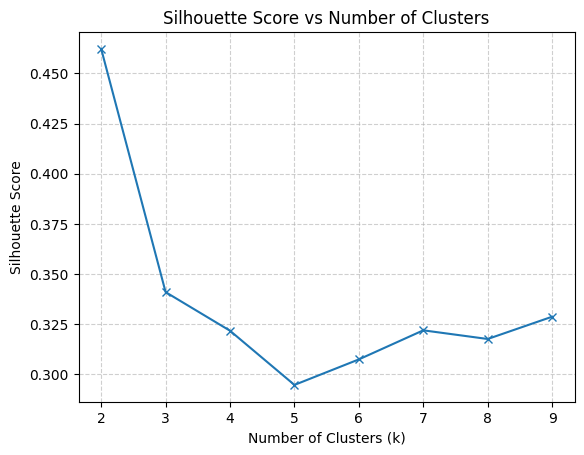

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

silhouette_values = []

for k in range(2, 10):
    print(f'fitting k = {k}')
    kmeans = KMeans(n_clusters=k, random_state=20, n_init=10)
    cluster_labels = kmeans.fit_predict(X_umap)
    
    # Calculate silhouette score
    score = silhouette_score(X_umap, cluster_labels)
    silhouette_values.append(score)

# plotting
plt.plot(range(2, 10), silhouette_values, marker='x')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

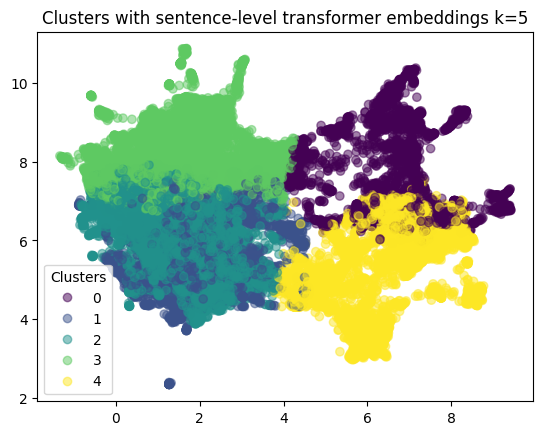


Central Sentences:
Cluster 0: Italy's Berlusconi sent to trial accused of bribing witness: source
--------------------------------------------------
Cluster 1: MAKE $250K A YEAR? You Could Qualify For Subsidized Housing In Palo Alto
--------------------------------------------------
Cluster 2: 3 FAILED GOP PRESIDENTIAL CANDIDATES Join Soros Funded Antifa, Mainstream Media To Twist Meaning of President Trump’s Words
--------------------------------------------------
Cluster 3: “COMEDIAN” GEORGE LOPEZ Who Said About Trump Supporters: “There Are Enough Racists In This Country To Get Him Elected” Goes On Vile Rant Against Woman…Makes Racist Comments [VIDEO]
--------------------------------------------------
Cluster 4: Mattis says will try to work with Pakistan 'one more time'
--------------------------------------------------


In [15]:
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt

elbow_point = 5

# Refit with optimal clusters
kmeans = KMeans(n_clusters=elbow_point, random_state=20, n_init = 10)
kmeans.fit(X_umap) # Fit using X_umap, as clustering was done on UMAP-reduced data

# Re-assign cluster labels based on the optimal clustering
cluster_assignments = kmeans.labels_

paragraphs = data['title'].tolist() # Use 'text_cleaned' which is a list of strings

central_sentences = []

for cluster_id in range(elbow_point):  # Use the optimal number of clusters

 # Extract the rows corresponding to the cluster from the original data (paragraphs)
 # And also the corresponding t-SNE coordinates for centroid calculation
 cluster_indices = (cluster_assignments == cluster_id)
 cluster_X_paragraphs = np.array(paragraphs)[cluster_indices]
 X_umap_cluster = X_umap[cluster_indices]

 if len(cluster_X_paragraphs) > 0:

  cluster_umap_points = X_umap[cluster_indices]
  if len(cluster_umap_points) > 0:
      centroid_umap = kmeans.cluster_centers_[cluster_id]

      distances_to_centroid = np.sum((cluster_umap_points - centroid_umap)**2, axis=1)
      closest_point_index_in_cluster_umap = np.argmin(distances_to_centroid)


      central_sentence = cluster_X_paragraphs[closest_point_index_in_cluster_umap]
      central_sentences.append(central_sentence)

# Look at the results
# Does the topics make sense?
# Get cluster assignments for each paragraph (already done above)

# Visualize clusters in 2D using X_umap
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title(f'Clusters with sentence-level transformer embeddings k={elbow_point}')
plt.show()

# Print central sentences
print("\nCentral Sentences:")
for i, sentence in enumerate(central_sentences):
 print(f"Cluster {i}: {sentence}\n{'-' * 50}")

In [16]:
data['cluster_id'] = cluster_assignments

# Group by cluster_id and label to see the distribution of true/fake articles in each cluster
cluster_label_distribution = data.groupby(['cluster_id', 'label']).size().unstack(fill_value=0)

cluster_label_distribution.rename(columns={0: 'Fake Articles', 1: 'True Articles'}, inplace=True)

display(cluster_label_distribution)

label,Fake Articles,True Articles
cluster_id,,
0,370,4536
1,1800,5370
2,6469,2843
3,8810,1472
4,450,6961


# Subjective

In [36]:
from transformers import pipeline

classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,
)
input_text = data['title_standard'][27143]

print(f"Title: {input_text}\nResult: {classify(input_text)}")

Device set to use mps:0


Title: trumps trying to attend muhammad alis muslim funeral – his familys response is brilliant
Result: [[{'label': 'SUBJECTIVE', 'score': 0.9244176745414734}, {'label': 'NEUTRAL', 'score': 0.07558233290910721}]]


/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


# Emotions

In [86]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=2)
text = data.loc[27000, 'title_standard']
print(text)
emotions = classifier(text)
print(emotions)

Device set to use mps:0


reports confirmed major corporate sponsor just ditched the rnc to boycott trump
[[{'label': 'surprise', 'score': 0.43607574701309204}, {'label': 'neutral', 'score': 0.42467039823532104}]]


# Subsetting dataframe with similar clusters

In [17]:
subset_df = data[data['cluster_id'].isin([1, 2])]

In [29]:
data['topic_predictions'].head()

0    {'label': 'politics', 'score': 0.9978227615356...
1    {'label': 'politics', 'score': 0.9927870631217...
2    {'label': 'politics', 'score': 0.9929057359695...
3    {'label': 'politics', 'score': 0.8195687532424...
4    {'label': 'economy, business and finance', 'sc...
Name: topic_predictions, dtype: object

In [19]:
cluster_1 = data[data['cluster_id'].isin([1])]
cluster_2 = data[data['cluster_id'].isin([2])]

In [30]:
for label in data['label'].unique():
    class_subset = data[data['label'] == label]
    

    topic_series = class_subset['topic_predictions'].apply(lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None)
    
    top_3_topics = topic_series.value_counts().head(3)
    
    label_name = "True" if label == 1 else "Fake"
    print(f"Top 3 topics for {label_name} (label {label}):")
    print(top_3_topics)
    print("-" * 30)

Top 3 topics for True (label 1):
topic_predictions
politics                   13545
conflict, war and peace     3915
crime, law and justice      1476
Name: count, dtype: int64
------------------------------
Top 3 topics for Fake (label 0):
topic_predictions
politics                   11764
crime, law and justice      1354
conflict, war and peace     1346
Name: count, dtype: int64
------------------------------


In [18]:
for label in subset_df['label'].unique():
    class_subset = subset_df[subset_df['label'] == label]
    

    topic_series = class_subset['topic_predictions'].apply(lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None)
    
    top_3_topics = topic_series.value_counts().head(3)
    
    label_name = "True" if label == 1 else "Fake"
    print(f"Top 3 topics for {label_name} (label {label}):")
    print(top_3_topics)
    print("-" * 30)

Top 3 topics for True (label 1):
topic_predictions
politics                         6491
crime, law and justice            561
economy, business and finance     500
Name: count, dtype: int64
------------------------------
Top 3 topics for Fake (label 0):
topic_predictions
politics                  6324
crime, law and justice     491
human interest             322
Name: count, dtype: int64
------------------------------


In [25]:
import pandas as pd
for label in subset_df['label'].unique():
    class_subset = subset_df[subset_df['label'] == label]
    
    # Udtrækker både emne og score til en liste af lister
    topic_data = []
    for x in class_subset['topic_predictions']:
        if isinstance(x, dict) and 'label' in x:
            topic_data.append([x['label'], x['score']])
    
    # Laver en midlertidig dataframe til nemmere beregning
    temp_df = pd.DataFrame(topic_data, columns=['topic', 'score'])
    
    # Finder top 3 emner baseret på antal (counts)
    top_3_counts = temp_df['topic'].value_counts().head(3)
    
    # Beregner gennemsnitlig score for hvert af de top 3 emner
    label_name = "True" if label == 1 else "Fake"
    print(f"Top 3 topics for {label_name} (label {label}):")
    
    for topic_name, count in top_3_counts.items():
        avg_score = temp_df[temp_df['topic'] == topic_name]['score'].mean()
        print(f"{topic_name}: {count} articles (Avg score: {avg_score:.4f})")
    
    print("-" * 30)

Top 3 topics for True (label 1):
politics: 6491 articles (Avg score: 0.9741)
crime, law and justice: 561 articles (Avg score: 0.9174)
economy, business and finance: 500 articles (Avg score: 0.8901)
------------------------------
Top 3 topics for Fake (label 0):
politics: 6324 articles (Avg score: 0.9721)
crime, law and justice: 491 articles (Avg score: 0.8934)
human interest: 322 articles (Avg score: 0.8339)
------------------------------


## Cluster 1

In [22]:
for label in cluster_1['label'].unique():
    class_subset = cluster_1[cluster_1['label'] == label]
    

    topic_series = class_subset['topic_predictions'].apply(lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None)
    
    top_3_topics = topic_series.value_counts().head(3)
    
    label_name = "True" if label == 1 else "Fake"
    print(f"Top 3 topics for {label_name} (label {label}):")
    print(top_3_topics)
    print("-" * 30)

Top 3 topics for True (label 1):
topic_predictions
politics                         4094
economy, business and finance     457
crime, law and justice            314
Name: count, dtype: int64
------------------------------
Top 3 topics for Fake (label 0):
topic_predictions
politics                         1332
crime, law and justice             96
economy, business and finance      90
Name: count, dtype: int64
------------------------------


## Cluster 2

In [23]:
for label in cluster_2['label'].unique():
    class_subset = cluster_2[cluster_2['label'] == label]
    

    topic_series = class_subset['topic_predictions'].apply(lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None)
    
    top_3_topics = topic_series.value_counts().head(3)
    
    label_name = "True" if label == 1 else "Fake"
    print(f"Top 3 topics for {label_name} (label {label}):")
    print(top_3_topics)
    print("-" * 30)

Top 3 topics for True (label 1):
topic_predictions
politics                   2397
crime, law and justice      247
conflict, war and peace     120
Name: count, dtype: int64
------------------------------
Top 3 topics for Fake (label 0):
topic_predictions
politics                  4992
crime, law and justice     395
human interest             297
Name: count, dtype: int64
------------------------------


In [92]:
from transformers import pipeline


classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)

results = classifier(subset_df['title_standard'].tolist(), truncation=True)

subset_df['emotion'] = [res[0]['label'] for res in results]
subset_df['emotion_score'] = [res[0]['score'] for res in results]

for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Emotions for {label_name} (label {label}):")
    print(subset_df[subset_df['label'] == label]['emotion'].value_counts())
    print("-" * 30)

Device set to use mps:0


Emotions for Fake (label 0):
emotion
anger       2453
neutral     2176
surprise    1073
sadness      938
fear         863
joy          459
disgust      307
Name: count, dtype: int64
------------------------------
Emotions for True (label 1):
emotion
neutral     4301
anger       1486
sadness     1016
fear         867
joy          348
surprise     158
disgust       37
Name: count, dtype: int64
------------------------------


/var/folders/2k/3k3j84pn3pz6hg3gmlkzyctr0000gn/T/ipykernel_67877/2172625899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['emotion'] = [res[0]['label'] for res in results]
/var/folders/2k/3k3j84pn3pz6hg3gmlkzyctr0000gn/T/ipykernel_67877/2172625899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['emotion_score'] = [res[0]['score'] for res in results]


In [93]:
from transformers import pipeline

# Initialiser pipeline
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,
)

# Kør batch-klassificering
results = classify(subset_df['title_standard'].tolist(), truncation=True)

# Udtræk den label der har den højeste score for hver række
def get_top_style(scores):
    return max(scores, key=lambda x: x['score'])['label']

subset_df['style'] = [get_top_style(res) for res in results]

# Tæl og print resultater for hver klasse
for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Style/Subjectivity for {label_name} (label {label}):")
    print(subset_df[subset_df['label'] == label]['style'].value_counts())
    print("-" * 30)

Device set to use mps:0
/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Style/Subjectivity for Fake (label 0):
style
SUBJECTIVE    7614
NEUTRAL        655
Name: count, dtype: int64
------------------------------
Style/Subjectivity for True (label 1):
style
SUBJECTIVE    4282
NEUTRAL       3931
Name: count, dtype: int64
------------------------------


/var/folders/2k/3k3j84pn3pz6hg3gmlkzyctr0000gn/T/ipykernel_67877/3611402283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['style'] = [get_top_style(res) for res in results]


# CLassifying with logistic regression

In [94]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Convert the Series of vectors into a 2D NumPy array (Matrix)
# This turns [ [v1, v2...], [v1, v2...] ] into a proper shape (N_samples, 768)
X = np.stack(data['aggregated_text_embedding'].values)

# 2. Assign your labels
y = data['label']

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Initialize and train
# We use 'lbfgs' (default) or 'sag' for faster convergence with large BERT vectors
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3580
           1       0.95      0.95      0.95      4237

    accuracy                           0.95      7817
   macro avg       0.95      0.95      0.95      7817
weighted avg       0.95      0.95      0.95      7817



In [95]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Convert the Series of vectors into a 2D NumPy array (Matrix)
# This turns [ [v1, v2...], [v1, v2...] ] into a proper shape (N_samples, 768)
X = np.stack(data['title_embedding'].values)

# 2. Assign your labels
y = data['label']

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Initialize and train
# We use 'lbfgs' (default) or 'sag' for faster convergence with large BERT vectors
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3580
           1       0.92      0.94      0.93      4237

    accuracy                           0.93      7817
   macro avg       0.93      0.93      0.93      7817
weighted avg       0.93      0.93      0.93      7817



In [96]:
import pandas as pd
import numpy as np

# 1. Get weights from the classifier you just trained
# clf.coef_ will now be shape (1, 384)
weights = clf.coef_[0]

# 2. Map Dimension Index to Weight
importance_df = pd.DataFrame({
    'Dimension_Index': range(len(weights)),
    'Weight': weights
})

# 3. Identify the "Smoking Guns"
# Sort by weight to see which dimensions drive the classification
top_fake = importance_df.sort_values(by='Weight', ascending=True).head(5)
top_true = importance_df.sort_values(by='Weight', ascending=False).head(5)

print("--- Top Dimensions predicting 'Fake' ---")
print(top_fake)

print("\n--- Top Dimensions predicting 'True' ---")
print(top_true)

--- Top Dimensions predicting 'Fake' ---
     Dimension_Index    Weight
145              145 -5.285448
48                48 -4.442596
209              209 -4.186894
222              222 -4.007560
287              287 -3.927192

--- Top Dimensions predicting 'True' ---
     Dimension_Index    Weight
90                90  5.885394
18                18  5.430504
152              152  4.685408
55                55  4.415868
163              163  4.409357


In [98]:
# Force target_dim to be an integer
target_dim = int(top_fake.iloc[0]['Dimension_Index'])

# Now the slicing [:, target_dim] will work perfectly
top_article_indices = np.argsort(X_test[:, target_dim])[-3:]

print(f"\nExample content for Dimension {target_dim}:")
for idx in top_article_indices:
    # IMPORTANT: If your data has been shuffled/split, 
    # make sure 'idx' refers to the correct original row.
    print(f"- {data['text'].iloc[idx][:150]}...")


Example content for Dimension 145:
- President Donald Trump forged a surprising deal with Democrats in Congress on Wednesday to extend the U.S. debt limit and provide government funding u...
- China on Tuesday rejected a plan by U.S. Republican presidential candidate Donald Trump to back out of a global climate change pact, saying a wise pol...
- U.S. Republican President-elect Donald Trump on Tuesday formally announced Exxon-Mobil Corp (XOM.N) chairman and CEO Rex Tillerson as his nomination t...


# No politics df

In [34]:
no_politics_df = data[data['topic_predictions'].apply(lambda x: x.get('label') if isinstance(x, dict) else None) != 'politics']

# Valgfrit: Reset index
no_politics_df = no_politics_df.reset_index(drop=True)

# Tjek det nye antal rækker
print(f"Original nr of rows: {len(data)}")
print(f"No politics df {len(no_politics_df)}")

Original nr of rows: 39081
No politics df 13772


In [49]:
politics_df = data[data['topic_predictions'].apply(lambda x: x.get('label') if isinstance(x, dict) else None) == 'politics']


politics_df = politics_df.reset_index(drop=True)

# Tjek det nye antal rækker
print(f"Original nr of rows: {len(data)}")
print(f"No politics df {len(politics_df)}")

Original nr of rows: 39081
No politics df 25309


## Cosine v2 without politics

In [42]:
text_features = np.stack(no_politics_df['aggregated_text_embedding'].to_numpy())
# Dimensionality reduction for better to handle large matrices
import umap

# Use the full title_embeddings matrix (UMAP can handle it better than t-SNE)
reducer = umap.UMAP(n_components=3, random_state=20)

X_umap = reducer.fit_transform(text_features)


/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [50]:
from sklearn.model_selection import train_test_split

#-------- Uncomment one of the text_features to choose between the title sentence embeddings or the text embeddings------------_"

text_features = np.stack(no_politics_df['title_embedding'].to_numpy())
#text_features = np.stack(no_politics_df['aggregated_text_embedding'].to_numpy())

X = text_features
y = no_politics_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [51]:
df_train = pd.DataFrame({'embeddings': list(X_train), 'label': y_train})

title_mean = df_train.groupby('label')['embeddings'].apply(
    lambda x: np.mean(np.stack(x.values), axis=0)
)

title_mean_true = title_mean[1]
title_mean_fake = title_mean[0]

In [52]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import classification_report, accuracy_score


mean_matrix = np.stack([title_mean_fake, title_mean_true])


distance_matrix = cosine_distances(X_test, mean_matrix)


y_pred = np.argmin(distance_matrix, axis=1)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Fake (0)', 'True (1)'])

print("---------ARTICLE TEXT")
print(f"Accuracy on unseen Test Set: {accuracy:.4f}")
print(report)

---------ARTICLE TEXT
Accuracy on unseen Test Set: 0.8538
              precision    recall  f1-score   support

    Fake (0)       0.83      0.87      0.85      2353
    True (1)       0.88      0.84      0.86      2709

    accuracy                           0.85      5062
   macro avg       0.85      0.85      0.85      5062
weighted avg       0.86      0.85      0.85      5062



# Subjective

In [53]:
# POLITICS ARTICLES

from transformers import pipeline

# Model
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,
)

results = classify(politics_df['title_standard'].tolist(), truncation=True)

def get_top_style(scores):
    return max(scores, key=lambda x: x['score'])['label']

politics_df['style'] = [get_top_style(res) for res in results]

# Tæl og print resultater for hver klasse
for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Style/Subjectivity for {label_name} (label {label}):")
    print(politics_df[politics_df['label'] == label]['style'].value_counts())
    print("-" * 30)

Device set to use mps:0
/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Style/Subjectivity for Fake (label 0):
style
SUBJECTIVE    10861
NEUTRAL         903
Name: count, dtype: int64
------------------------------
Style/Subjectivity for True (label 1):
style
NEUTRAL       6785
SUBJECTIVE    6760
Name: count, dtype: int64
------------------------------


In [59]:
# ALL ARTICLES

from transformers import pipeline

# Model
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,
)

results = classify(data['title_standard'].tolist(), truncation=True)

def get_top_style(scores):
    return max(scores, key=lambda x: x['score'])['label']

data['style'] = [get_top_style(res) for res in results]

# Tæl og print resultater for hver klasse
for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Style/Subjectivity for {label_name} (label {label}):")
    print(data[data['label'] == label]['style'].value_counts())
    print("-" * 30)

Device set to use mps:0
/opt/anaconda3/envs/NewsExam_env/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Style/Subjectivity for Fake (label 0):
style
SUBJECTIVE    16277
NEUTRAL        1622
Name: count, dtype: int64
------------------------------
Style/Subjectivity for True (label 1):
style
NEUTRAL       10995
SUBJECTIVE    10187
Name: count, dtype: int64
------------------------------


# Emotions

In [57]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=2)

results = classifier(subset_df['title_standard'].tolist(), truncation=True)

# Udtræk den label der har den højeste score for hver række
def get_top_style(scores):
    return max(scores, key=lambda x: x['score'])['label']

subset_df['style'] = [get_top_style(res) for res in results]

# Tæl og print resultater for hver klasse
for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Emotions for {label_name} (label {label}):")
    print(subset_df[subset_df['label'] == label]['style'].value_counts())
    print("-" * 30)

Device set to use mps:0


Emotions for Fake (label 0):
style
anger       2453
neutral     2176
surprise    1073
sadness      938
fear         863
joy          459
disgust      307
Name: count, dtype: int64
------------------------------
Emotions for True (label 1):
style
neutral     4301
anger       1486
sadness     1016
fear         867
joy          348
surprise     158
disgust       37
Name: count, dtype: int64
------------------------------


/var/folders/2k/3k3j84pn3pz6hg3gmlkzyctr0000gn/T/ipykernel_83734/642518145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['style'] = [get_top_style(res) for res in results]


In [60]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=2)

results = classifier(data['title_standard'].tolist(), truncation=True)


def get_top_style(scores):
    return max(scores, key=lambda x: x['score'])['label']

data['emotions'] = [get_top_style(res) for res in results]


for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Emotions for {label_name} (label {label}):")
    print(data[data['label'] == label]['emotions'].value_counts())
    print("-" * 30)

Device set to use mps:0


Emotions for Fake (label 0):
style
SUBJECTIVE    16277
NEUTRAL        1622
Name: count, dtype: int64
------------------------------
Emotions for True (label 1):
style
NEUTRAL       10995
SUBJECTIVE    10187
Name: count, dtype: int64
------------------------------


In [61]:
for label in [0, 1]:
    label_name = "True" if label == 1 else "Fake"
    print(f"Emotions for {label_name} (label {label}):")
    print(data[data['label'] == label]['emotions'].value_counts())
    print("-" * 30)

Emotions for Fake (label 0):
emotions
anger       5657
neutral     4223
surprise    2112
fear        2062
sadness     1842
joy         1238
disgust      765
Name: count, dtype: int64
------------------------------
Emotions for True (label 1):
emotions
neutral     9118
anger       4545
sadness     3059
fear        2819
joy         1210
surprise     314
disgust      117
Name: count, dtype: int64
------------------------------


# Decicion tree

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Use clusters since these are made based on embeddings. Using acutal embeddings does not yield much better result and complicated decision making progress
features_embeddings = pd.DataFrame(data['cluster_id']).reset_index(drop=True)


features_meta = pd.get_dummies(data[['style', 'emotions']]).reset_index(drop=True)

# Combine
X = pd.concat([features_embeddings, features_meta], axis=1)
y = data['label']

X.columns = X.columns.astype(str)
# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Start tree
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3569
           1       0.86      0.85      0.86      4248

    accuracy                           0.84      7817
   macro avg       0.84      0.84      0.84      7817
weighted avg       0.84      0.84      0.84      7817



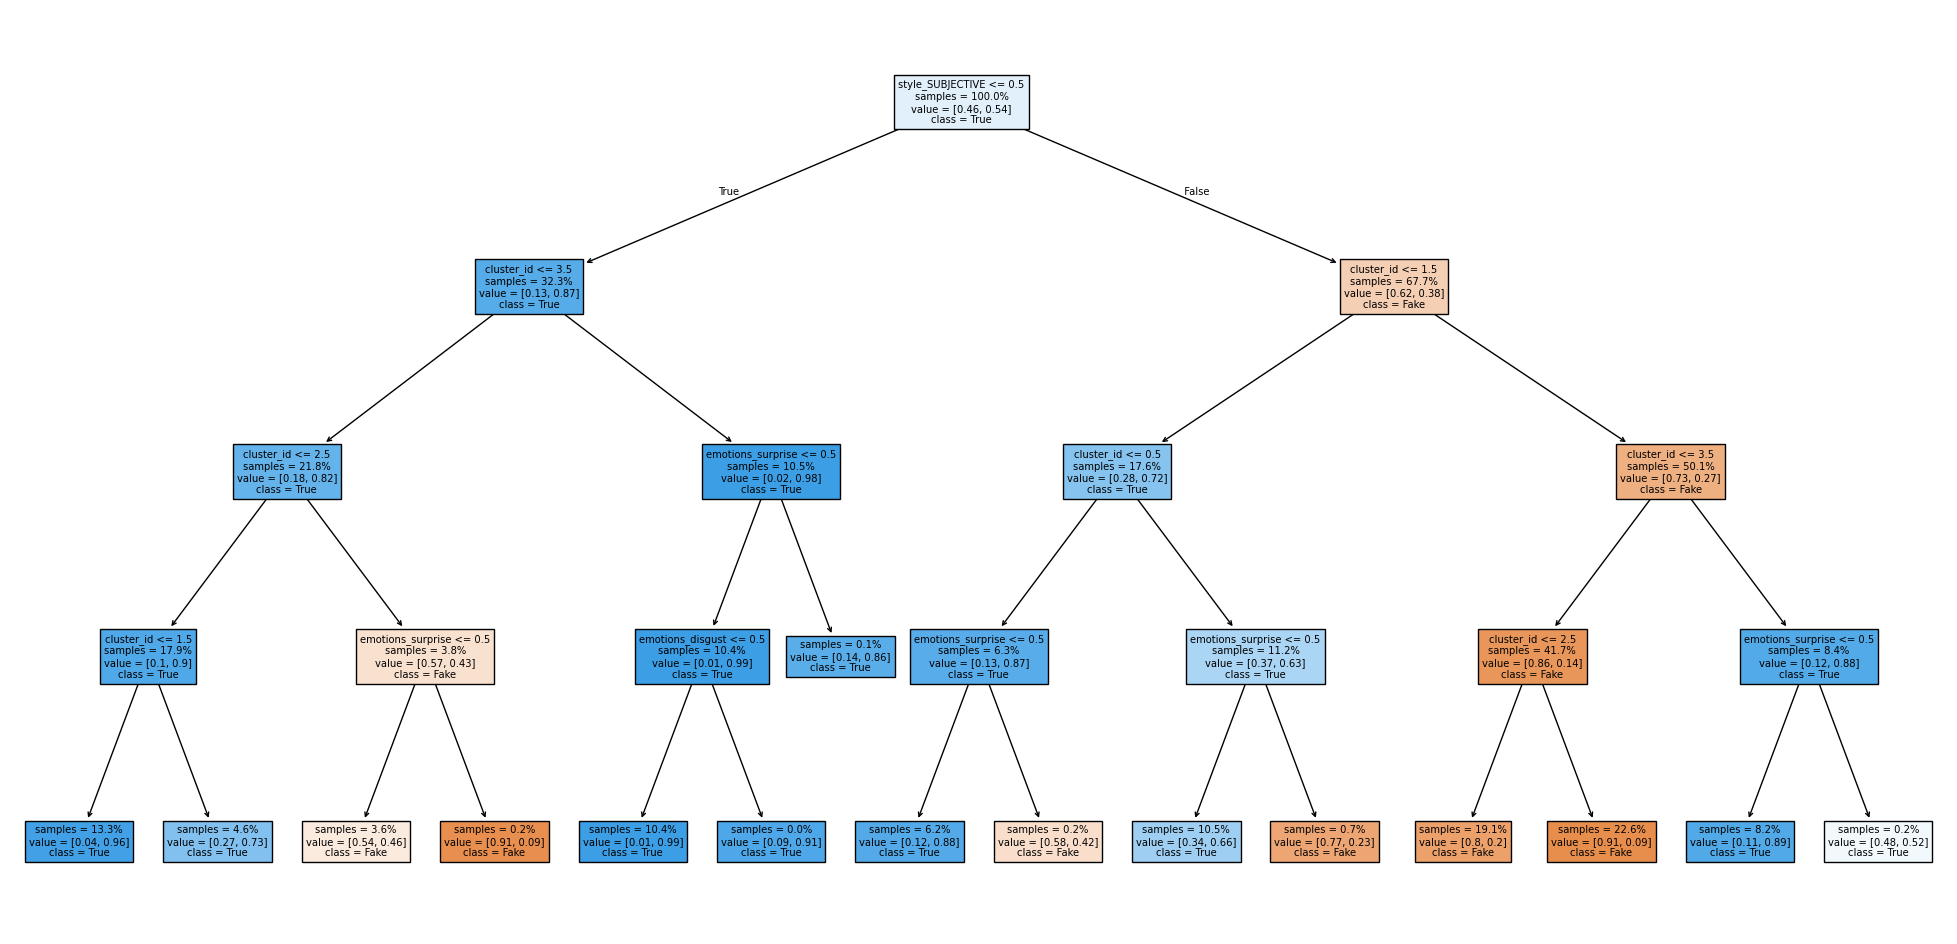

In [162]:
# Plotting

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,12))
plot_tree(tree_clf, 
          feature_names=X.columns, 
          class_names=['Fake', 'True'], 
          filled=True, 
          impurity=False, 
          proportion=True, 
          precision=2
          )
plt.savefig("decisiontree.png", dpi=300, bbox_inches='tight') 
plt.show()





In [ ]:
# Gem som PDF (bedste valg til Overleaf)
plt.savefig("decisiontree.pdf", bbox_inches='tight')

# ELLER gem som PNG med meget høj opløsning
plt.savefig("decisiontree.png", dpi=300, bbox_inches='tight')

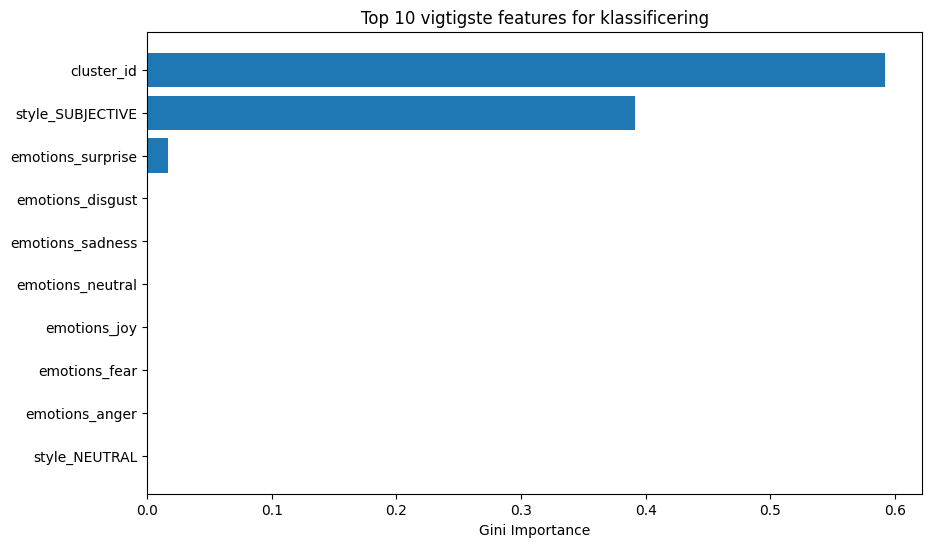

In [163]:
import numpy as np

# Find de vigtigste features
importances = tree_clf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.title("Top 10 vigtigste features for klassificering")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Gini Importance")
plt.show()